Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 1 2021/2022
http://www.fer.unizg.hr/predmet/struce1

------------------------------

### Logistička regresija

*Verzija: 1.0 
Zadnji put ažurirano: 1. 10. 2021.*

(c) 2015-2021 Jan Šnajder, Domagoj Alagić  

Rok za predaju: **7. studenog 2021. u 23:59h**

------------------------------

### Upute

Ova laboratorijska vježba sastoji se od četiri zadatka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [1]:
# Učitaj osnovne biblioteke...
import sklearn
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.04  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

### 1. Logistička regresija

Ovaj zadatak bavi se probabilističkim diskriminativnim modelom, **logističkom regresijom**, koja je, unatoč nazivu, klasifikacijski model.

Logistička regresija tipičan je predstavnik tzv. **poopćenih linearnih modela** koji su oblika: $h(\mathbf{x})=f(\mathbf{w}^\intercal\tilde{\mathbf{x}})$. Logistička funkcija za funkciju $f$ koristi tzv. **logističku** (sigmoidalnu) funkciju $\sigma (x) = \frac{1}{1 + \textit{exp}(-x)}$.

### (a)  

Definirajte logističku (sigmoidalnu) funkciju $\mathrm{sigm}(x)=\frac{1}{1+\exp(-\alpha x)}$ i prikažite je za $\alpha\in\{1,2,4\}$.

In [3]:
import numpy as np

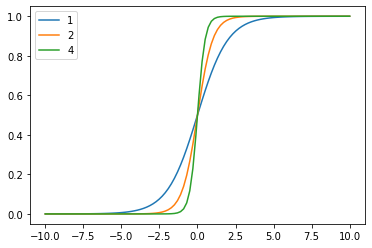

In [4]:
# Vaš kôd ovdje
def sigm(x):
    return 1 / (1 + np.exp(-x))

x = np.linspace(-10,10,100)
alphas = [1, 2, 4]
for a in alphas:
    plt.plot(x, sigm(a*x), label=str(a))
plt.legend()
plt.show()

**Q**: Zašto je sigmoidalna funkcija prikladan izbor za aktivacijsku funkciju poopćenoga linearnog modela? 
</br>

**Q**: Kakav utjecaj ima faktor $\alpha$ na oblik sigmoide? Što to znači za model logističke regresije (tj. kako izlaz modela ovisi o normi vektora težina $\mathbf{w}$)?

### (b) 

Implementirajte funkciju 

> `lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False)` 

za treniranje modela logističke regresije gradijentnim spustom (*batch* izvedba). Funkcija uzima označeni skup primjera za učenje (matrica primjera `X` i vektor oznaka `y`) te vraća $(n+1)$-dimenzijski vektor težina tipa `ndarray`. Ako je `trace=True`, funkcija dodatno vraća listu (ili matricu) vektora težina $\mathbf{w}^0,\mathbf{w}^1,\dots,\mathbf{w}^k$ generiranih kroz sve iteracije optimizacije, od 0 do $k$. Optimizaciju treba provoditi dok se ne dosegne `max_iter` iteracija, ili kada razlika u pogrešci unakrsne entropije između dviju iteracija padne ispod vrijednosti `epsilon`. Parametar `alpha` predstavlja faktor L2-regularizacije.

Preporučamo definiranje pomoćne funkcije `lr_h(x,w)` koja daje predikciju za primjer `x` uz zadane težine `w`. Također, preporučamo i funkciju `cross_entropy_error(X,y,w)` koja izračunava pogrešku unakrsne entropije modela na označenom skupu `(X,y)` uz te iste težine.

**NB:** Obratite pozornost na to da je način kako su definirane oznake ($\{+1,-1\}$ ili $\{1,0\}$) kompatibilan s izračunom funkcije gubitka u optimizacijskome algoritmu.

In [5]:
from sklearn.preprocessing import PolynomialFeatures

def lr_h(x,w):
    p = PolynomialFeatures(degree=1)
    phi = p.fit_transform([x]) 
    return sigm(phi.dot(w))

def cross_entropy_error(X,y,w):
    err = 0
    N = X.shape[0]
    for (x_i, y_i) in zip(X, y):
        err += -y_i*math.log(lr_h(x_i, w)) - (1-y_i)*math.log(1-lr_h(x_i, w))
    return err/N

In [6]:
from numpy import linalg

def lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False):
    # Vaš kôd ovdje
    w = np.zeros(X.shape[1] + 1)
    iter_cnt = 0
    cross_err = cross_entropy_error(X, y, w)
    w_trace = []
    
    while iter_cnt < max_iter:
        iter_cnt += 1
        delta_w0 = 0
        delta_w = np.zeros(X.shape[1])
        for (x_i, y_i) in zip(X, y):           
            h_i = lr_h(x_i, w)
            delta_w0 -=  (h_i - y_i)*1
            delta_w -= (h_i - y_i)*x_i
            
        w[0] = w[0] + eta*delta_w0
        w[1:] = w[1:]*(1-eta*alpha) + eta*delta_w
        
        if trace:
            w_trace.append(w.copy())
            
        new_cross_err = cross_entropy_error(X, y, w)
        if np.abs(cross_err - new_cross_err) < epsilon:
            if trace:
                return w, w_trace
            else:
                return w
        cross_err = new_cross_err
        
    if trace:
        return w, w_trace
    else:
        return w
        

### (c)

Koristeći funkciju `lr_train`, trenirajte model logističke regresije na skupu `seven`, prikažite dobivenu granicu između klasa te  izračunajte pogrešku unakrsne entropije. 

**NB:** Pripazite da modelu date dovoljan broj iteracija.

In [7]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

Broj iteracija je: 947
Pogreška unakrsne entropije iznosi: 0.13521872720206746


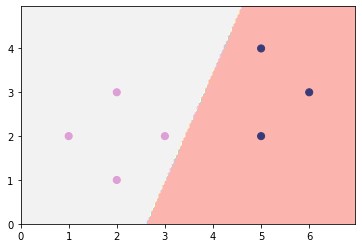

In [8]:
# Vaš kôd ovdje
w, w_trace = lr_train(seven_X, seven_y, max_iter=2000, trace=True)
print('Broj iteracija je: {}'.format(len(w_trace)))
plot_2d_clf_problem(seven_X, seven_y, h=lambda x: lr_h(x,w) >= 0.5)
print('Pogreška unakrsne entropije iznosi: {}'.format(cross_entropy_error(seven_X, seven_y, w)))

**Q:** Koji kriterij zaustavljanja je aktiviran?

**Q:** Zašto dobivena pogreška unakrsne entropije nije jednaka nuli?

**Q:** Kako biste utvrdili da je optimizacijski postupak doista pronašao hipotezu koja minimizira pogrešku učenja? O čemu to ovisi?

**Q:** Na koji način biste preinačili kôd ako biste htjeli da se optimizacija izvodi stohastičkim gradijentnim spustom (*online learning*)?

### (d)

Prikažite na jednom grafikonu pogrešku unakrsne entropije (očekivanje logističkog gubitka) i pogrešku klasifikacije (očekivanje gubitka 0-1) na skupu `seven` kroz iteracije optimizacijskog postupka. Koristite trag težina funkcije `lr_train` iz zadatka (b) (opcija `trace=True`). Na drugom grafikonu prikažite pogrešku unakrsne entropije kao funkciju broja iteracija za različite stope učenja, $\eta\in\{0.005,0.01,0.05,0.1\}$.

In [99]:
from sklearn.metrics import zero_one_loss

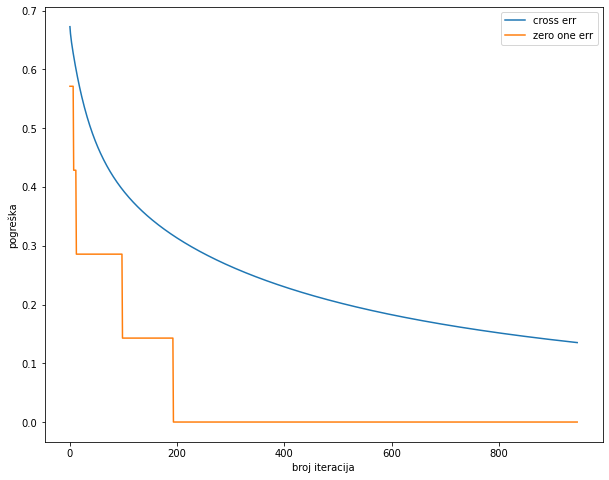

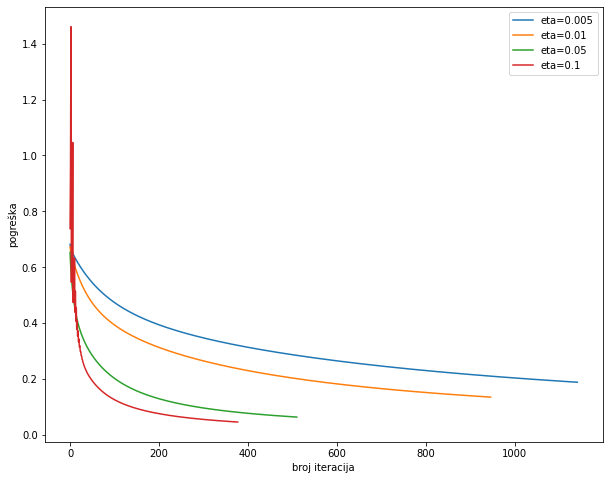

In [106]:
# Vaš kôd ovdje
w, w_trace = lr_train(seven_X, seven_y, max_iter=2000, trace=True)
x = [i for i in range(len(w_trace))]
cross_errs = []
zero_one_err = []
for w_i in w_trace:
    cross_errs.append(cross_entropy_error(seven_X, seven_y, w_i))
    y_pred = []
    for x_i in seven_X:
        y_pred.append(int(lr_h(x_i,w_i) >= 0.5))
    zero_one_err.append(zero_one_loss(seven_y, y_pred))
plt.figure(figsize=(10, 8))
plt.plot(x, cross_errs, label='cross err')
plt.plot(x, zero_one_err, label='zero one err')
plt.xlabel('broj iteracija')
plt.ylabel('pogreška')
plt.legend()
plt.show()

etas = [0.005,0.01,0.05,0.1]
plt.figure(figsize=(10, 8))
for e in etas:
    cross_errs = []
    w, w_trace = lr_train(seven_X, seven_y, eta=e, max_iter=2000, trace=True)#kolki max_iter da bude?
    x = [i for i in range(len(w_trace))]
    for w_i in w_trace:
        cross_errs.append(cross_entropy_error(seven_X, seven_y, w_i))
    plt.plot(x, cross_errs, label='eta='+str(e))    
plt.xlabel('broj iteracija')
plt.ylabel('pogreška')
plt.legend()
plt.show()


**Q:** Zašto je pogreška unakrsne entropije veća od pogreške klasifikacije? Je li to uvijek slučaj kod logističke regresije i zašto?

**Q:** Koju stopu učenja $\eta$ biste odabrali i zašto?

### (e)

Upoznajte se s klasom [`linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) koja implementira logističku regresiju. Usporedite rezultat modela na skupu `seven` s rezultatom koji dobivate pomoću vlastite implementacije algoritma.

**NB:** Kako ugrađena implementacija koristi naprednije verzije optimizacije funkcije, vrlo je vjerojatno da Vam se rješenja neće poklapati, ali generalne performanse modela bi trebale. Ponovno, pripazite na broj iteracija i snagu regularizacije.

In [10]:
from sklearn.linear_model import LogisticRegression
# Vaš kôd ovdje
clf = LogisticRegression().fit(seven_X, seven_y)#to je s L2 regularizacijom, bez regularizacije daje 46.26968486, -14.80304235, 4.33454163 
y_pred = clf.predict(seven_X)
print('Klasa LogisticRegression rezultati:')
print('Predikcije: {}'.format(y_pred))
print('Težine: {}, {}'.format(clf.intercept_, clf.coef_))

w = lr_train(seven_X, seven_y, max_iter=2000)
my_y_pred = np.array([int(lr_h(x_i, w) >= 0.5) for x_i in seven_X])
print('Rezultati dobiveni pomoću lr_train():')
print('Predikcije: {}'.format(my_y_pred))
print('Težine: {}'.format(w))

Klasa LogisticRegression rezultati:
Predikcije: [1 1 1 1 0 0 0]
Težine: [5.33129609], [[-1.18244419 -0.30251926]]
Rezultati dobiveni pomoću lr_train():
Predikcije: [1 1 1 1 0 0 0]
Težine: [ 4.45449454 -1.71089242  0.68413507]


### 2. Analiza logističke regresije

### (a)

Koristeći ugrađenu implementaciju logističke regresije, provjerite kako se logistička regresija nosi s vrijednostima koje odskaču. Iskoristite skup `outlier`. Prikažite granicu između klasa.

In [12]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

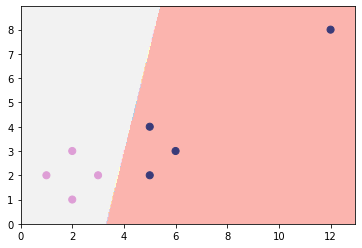

In [13]:
# Vaš kôd ovdje
clf = LogisticRegression(penalty='none').fit(outlier_X, outlier_y) #drugaciji rezultat sa i bez regularizacije
plot_2d_clf_problem(outlier_X, outlier_y, h=lambda x: clf.predict(x))

**Q:** Zašto se rezultat razlikuje od onog koji je dobio model klasifikacije linearnom regresijom iz prvog zadatka?

### (b)

Trenirajte model logističke regresije na skupu `seven` te na dva odvojena grafikona prikažite, kroz iteracije optimizacijskoga algoritma, (1) izlaz modela $h(\mathbf{x})$ za svih sedam primjera te (2) vrijednosti težina $w_0$, $w_1$, $w_2$.

In [14]:
# Vaš kôd ovdje
def plot_2_graphs(X, y):
    w, w_trace = lr_train(X, y, max_iter=2000, trace=True)
    iters = [i for i in range(len(w_trace))]
    n = X.shape[0]
    h = [[] for i in range(n)]
    for w_i in w_trace:
        for (x_i, h_i) in zip(X, h):
            h_i.append(lr_h(x_i, w_i)[0])
            
    plt.title('(1) izlazi modela')
    for i in range(n):
        plt.plot(iters, h[i], label=X[i])
    plt.legend()
    plt.show()

    w_trace = np.array(w_trace)
    plt.title('(2) vrijednosti težina')
    plt.plot(iters, w_trace[:, 0], label='w0')
    plt.plot(iters, w_trace[:, 1], label='w1')
    plt.plot(iters, w_trace[:, 2], label='w2')
    plt.legend()
    plt.show()

[1 1 1 1 0 0 0]


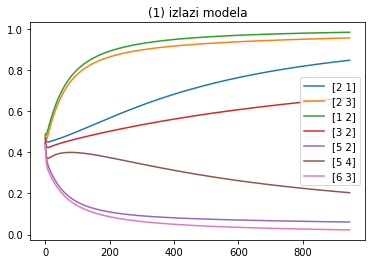

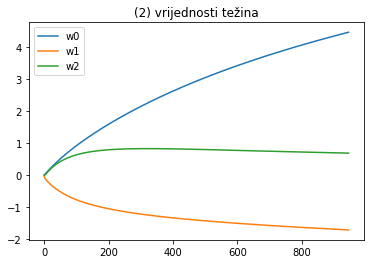

In [15]:
print(seven_y)
plot_2_graphs(seven_X, seven_y)

### (c)

Ponovite eksperiment iz podzadatka (b) koristeći linearno neodvojiv skup podataka `unsep`.

In [16]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

[1 1 1 1 0 0 0 0]


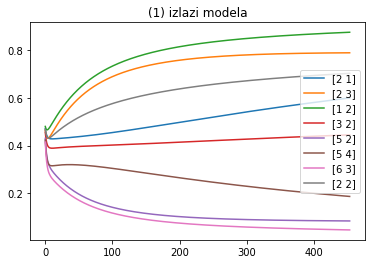

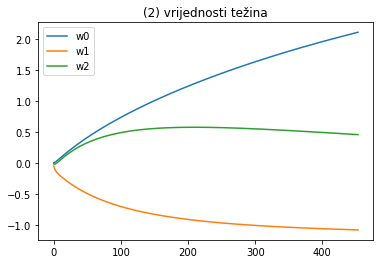

In [17]:
# Vaš kôd ovdje
print(unsep_y)
plot_2_graphs(unsep_X, unsep_y)

**Q:** Usporedite grafikone za slučaj linearno odvojivih i linearno neodvojivih primjera te komentirajte razliku.

### 3. Regularizirana logistička regresija

Trenirajte model logističke regresije na skupu `seven` s različitim faktorima L2-regularizacije, $\alpha\in\{0,1,10,100\}$. Prikažite na dva odvojena grafikona (1) pogrešku unakrsne entropije te (2) L2-normu vektora $\mathbf{w}$ kroz iteracije optimizacijskog algoritma.

In [18]:
from numpy.linalg import norm

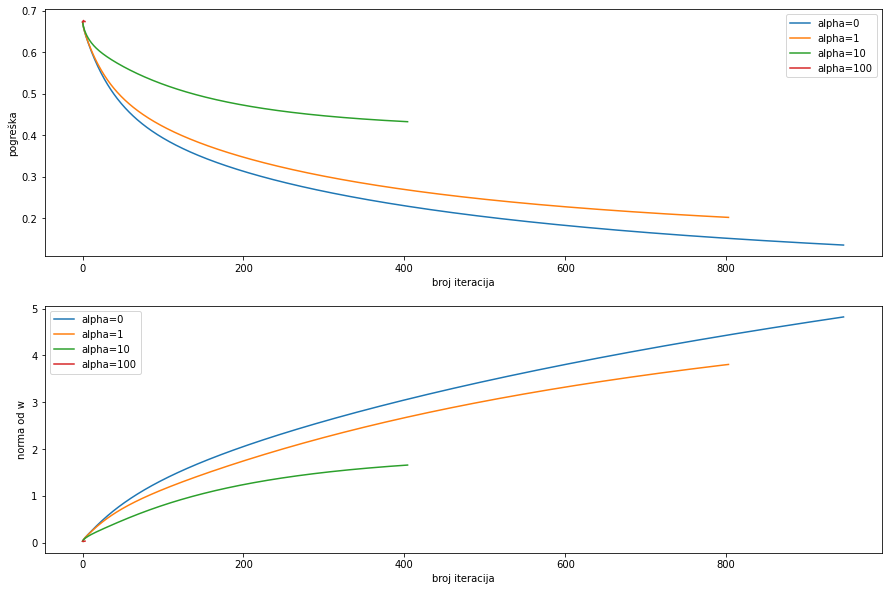

In [19]:
# Vaš kôd ovdje
alphas = [0, 1, 10, 100]
fig, (ax1, ax2) = plt.subplots(2)
fig.set_size_inches(15, 10)
for a in alphas:
    w, w_trace = lr_train(seven_X, seven_y, max_iter=2000, alpha=a, trace=True)
    iters = [i for i in range(len(w_trace))]
    cross_err = []
    w2_norm = []
    for w_i in w_trace:
        cross_err.append(cross_entropy_error(seven_X, seven_y, w_i))
        w2_norm.append(norm(w_i))
    ax1.plot(iters, cross_err, label='alpha=' + str(a))
    ax2.plot(iters, w2_norm, label='alpha=' + str(a))
    
ax1.set_ylabel('pogreška')
ax1.set_xlabel('broj iteracija')
ax1.legend()
ax2.set_ylabel('norma od w')
ax2.set_xlabel('broj iteracija')
ax2.legend()

**Q:** Jesu li izgledi krivulja očekivani i zašto?

**Q:** Koju biste vrijednost za $\alpha$ odabrali i zašto?

### 4. Logistička regresija s funkcijom preslikavanja

Proučite funkciju [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Generirajte i prikažite dvoklasan skup podataka s ukupno $N=100$ dvodimenzijskih ($n=2)$ primjera, i to sa dvije grupe po klasi (`n_clusters_per_class=2`). Malo je izgledno da će tako generiran skup biti linearno odvojiv, međutim to nije problem jer primjere možemo preslikati u višedimenzijski prostor značajki pomoću klase [`preprocessing.PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html), kao što smo to učinili kod linearne regresije u prvoj laboratorijskoj vježbi. Trenirajte model logističke regresije koristeći za preslikavanje u prostor značajki polinomijalnu funkciju stupnja $d=2$ i stupnja $d=3$. Prikažite dobivene granice između klasa. Možete koristiti svoju implementaciju, ali se radi brzine preporuča koristiti `linear_model.LogisticRegression`. Regularizacijski faktor odaberite po želji.

**NB:** Kao i ranije, za prikaz granice između klasa koristite funkciju `plot_2d_clf_problem`. Funkciji kao argumente predajte izvorni skup podataka, a preslikavanje u prostor značajki napravite unutar poziva funkcije `h` koja čini predikciju, na sljedeći način:

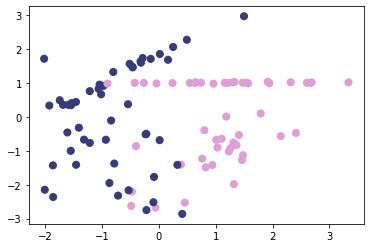

In [20]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import make_classification
#plot_2d_clf_problem(X, y, lambda x : model.predict(poly.transform(x))
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_classes=2, n_clusters_per_class=2)
plot_2d_clf_problem(X, y)

0.89

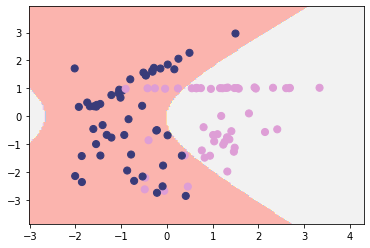

In [28]:
# Vaš kôd ovdje
p = PolynomialFeatures(degree=2)
phi_2 = p.fit_transform(X)
model = LogisticRegression(C=0.001) #probaj razlicite reg faktore
model.fit(phi_2, y)
plot_2d_clf_problem(X, y, lambda x : model.predict(p.fit_transform(x)))
model.score(phi_2, y)

0.81

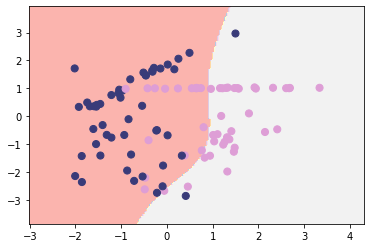

In [29]:
p = PolynomialFeatures(degree=3)
phi_3 = p.fit_transform(X)
model = LogisticRegression(C=0.0001) #probaj razlicite reg faktore
model.fit(phi_3, y)
plot_2d_clf_problem(X, y, lambda x : model.predict(p.fit_transform(x)))
model.score(phi_3, y)

**Q:** Koji biste stupanj polinoma upotrijebili i zašto? Je li taj odabir povezan s odabirom regularizacijskog faktora $\alpha$? Zašto?